# Handwritten Digit Classfication using Convolutional Neural Network

The tutorial presented will again tackle the MNIST digit classification problem. You can find more information from the previous [MNIST introduction](introduction_to_mnist.ipynb) tutorial. This time, we will build a Convolutional Neural Network which is vastly used in many different applications. CNN are networks with loops in them, allowing information to persist. Take a look at [this great blog](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) to gain insights of CNN.

In [10]:
import matplotlib
# matplotlib.use('Agg')
%pylab inline

import pandas
import datetime as dt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from pyspark import SparkContext
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))
redire_spark_logs()
show_bigdl_info_logs()
init_engine()

Populating the interactive namespace from numpy and matplotlib


In [4]:
def get_mnist(sc, mnist_path):
    # target is start from 0,
    (train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")
    (test_images, test_labels) = mnist.read_data_sets(mnist_path, "test")
    training_mean = np.mean(train_images)
    training_std = np.std(train_images)
    rdd_train_images = sc.parallelize(train_images)
    rdd_train_labels = sc.parallelize(train_labels)
    rdd_test_images = sc.parallelize(test_images)
    rdd_test_labels = sc.parallelize(test_labels)
    
    rdd_train_sample = rdd_train_images.zip(rdd_train_labels).map(lambda (features, label):
                    Sample.from_ndarray((features - training_mean)/training_std, label + 1))
    rdd_test_sample = rdd_test_images.zip(rdd_test_labels).map(lambda (features, label):
                    Sample.from_ndarray((features - training_mean)/training_std, label + 1))
    return (rdd_train_sample, rdd_test_sample)

## 1. Train the network

First, we should get and store MNIST into RDD of Sample.

Note: *edit the "mnist_path" accordingly. If the "mnist_path" directory does not consist of the mnist data, mnist.read_data_sets method will download the dataset directly to the directory*.

In [5]:
# Get and store MNIST into RDD of Sample, please edit the "mnist_path" accordingly.
mnist_path = "datasets/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)

print train_data.count()
print test_data.count()

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


## 2. Model creation

Let's create the LeNet-5 model.

In [6]:
# Create a LeNet model
def build_model(class_num):
    model = Sequential()
    model.add(Reshape([1, 28, 28]))
    model.add(SpatialConvolution(1, 6, 5, 5).set_name('conv1'))
    model.add(Tanh())
    model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool1'))
    model.add(Tanh())
    model.add(SpatialConvolution(6, 12, 5, 5).set_name('conv2'))
    model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool2'))
    model.add(Reshape([12 * 4 * 4]))
    model.add(Linear(12 * 4 * 4, 100).set_name('fc1'))
    model.add(Tanh())
    model.add(Linear(100, class_num).set_name('score'))
    model.add(LogSoftMax())
    return model
lenet_model = build_model(10)

creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createTanh
creating: createSpatialMaxPooling
creating: createTanh
creating: createSpatialConvolution
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createTanh
creating: createLinear
creating: createLogSoftMax


## 3. Optimizer setup and training

In [7]:
# Create an Optimizer

optimizer = Optimizer(
    model=lenet_model,
    training_rdd=train_data,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=0.4, learningrate_decay=0.0002),
    end_trigger=MaxEpoch(20),
    batch_size=2048)

# Set the validation logic
optimizer.set_validation(
    batch_size=2048,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='lenet-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print "saving logs to ",app_name

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  lenet-20180409-105610


* Train the network. Wait some time till it finished.. Voila! You've got a trained model

In [8]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 15.3 ms, sys: 6.87 ms, total: 22.2 ms
Wall time: 2min 9s


## 4. Predication on test data

In [ ]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l[0] - 1

Let's first take a few traing samples and check the labels

In [ ]:
# label-1 to restore the original label.
print "Ground Truth labels:" 
print ', '.join([str(map_groundtruth_label(s.label.to_ndarray())) for s in train_data.take(8)])
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) for s in train_data.take(8)]),cmap='gray'); plt.axis('off')

Now, let's see the prediction results on test data by our trained model.

In [ ]:
%%time
predictions = trained_model.predict(test_data)
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); plt.axis('off')
print 'Ground Truth labels:'
print ', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(8))
print 'Predicted labels:'
print ', '.join(str(map_predict_label(s)) for s in predictions.take(8))

## 5. Model inspection

Now look at the parameter shapes. The parameters are exposed as a dict, and can be retrieved using model.parameters().

The param shapes typically have the form (batch_number?, output_channels, input_channels, filter_height, filter_width) (for the weights) and the 1-dimensional shape (output_channels,) (for the biases).

In [15]:
params = trained_model.parameters()

#batch num, output_dim, input_dim, spacial_dim
for layer_name, param in params.iteritems():
    print layer_name,param['weight'].shape,param['bias'].shape

conv2 (1, 12, 6, 5, 5) (12,)
conv1 (1, 6, 1, 5, 5) (6,)
score (10, 100) (10,)
fc1 (100, 192) (100,)


## 6. Weight visualiztion

Then let's demonstrate how to visualize the weights of convolutional layers in the model.

In [16]:
#vis_square is borrowed from caffe example
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
  
    plt.imshow(data,cmap='gray'); plt.axis('off')

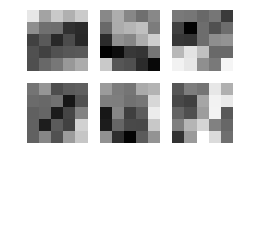

In [17]:
filters_conv1 = params['conv1']['weight']

filters_conv1[0,0,0]

vis_square(np.squeeze(filters_conv1, axis=(0,)).reshape(1*6,5,5))

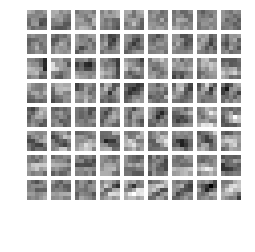

In [18]:
# the parameters are a list of [weights, biases]
filters_conv2 = params['conv2']['weight']

vis_square(np.squeeze(filters_conv2, axis=(0,)).reshape(12*6,5,5))

## 7. Loss visualization

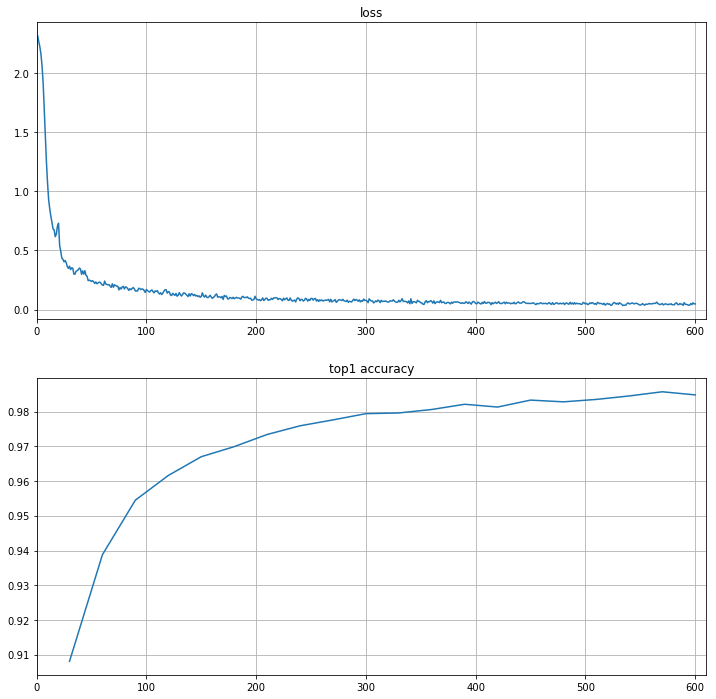

In [19]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)
